In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from PIL import Image
import random

In [2]:
classes = ["basophil", "eosinophil", "neutrophil"]
class2idx = {"basophil" : 0, "eosinophil" : 1, "neutrophil" : 2}
idx2class = {0 : "basophil", 1 : "eosinophil", 2 : "neutrophil"}

In [3]:
file_path = "./bloodcells_dataset/"     # make sure it ends with bloodcells_dataset/ so we can access the different subfolders
baso = [f for f in listdir(file_path + "basophil") if isfile(join(file_path + "basophil", f)) and f != ".DS_Store"]
eosi = [f for f in listdir(file_path + "eosinophil") if isfile(join(file_path + "eosinophil", f)) and f != ".DS_Store"]
neutro = [f for f in listdir(file_path + "neutrophil") if isfile(join(file_path + "neutrophil", f)) and f != ".DS_Store"]
data = baso + eosi + neutro
random.shuffle(data)

*   `__init__()`: Takes in the file path of the image folders, the list of file names we just gathered, and one of two modes - `train` or `test`. If the mode is `train`, then we will create the training test. If the mode is `test`, the entire testing data will be fetched at once to save time as we don't have that many testing images.
*   `__len__()`: Returns the length of the dataset, # of samples.
*   `__getitem__()`: Gets an input `i` and returns a tuple of `(data[i], label[i])`. In this method, we will only read the image from the disk every time a sample is requested. This helps us save space and can ensure CUDA out of memory errors never happening. This method also does some quick preprocessing, it makes sure that all images are of size `(3, 363, 360)`.

In [4]:
class BloodCell_Dataset(Dataset):
    def __init__(self, file_path, file_path_list, mode="train", test_size=0.2):
        self.file_path = file_path
        self.classes = ["basophil", "eosinophil", "neutrophil"]
        self.class2idx = {"basophil" : 0, "eosinophil" : 1, "neutrophil" : 2}
        self.idx2class = {0 : "basophil", 1 : "eosinophil", 2 : "neutrophil"}
        self.data = file_path_list
        assert mode in ['train', 'test'], f'mode needs to be either train or test, but it\'s {mode}'
        partition = int(len(self.data) * (1 - test_size))
        if mode == 'train':
            self.data = self.data[:partition]
        else:
            self.data = self.data[partition:]
            self.tensor_imgs = []
            self.labels = []
            for i in range(len(self.data)):
                img, label = self.__getitem__(i)                                
                if len(img.shape) == 3:                                         
                    img = img.unsqueeze(0)                                      
                self.tensor_imgs.append(img)
                self.labels.append(label.item())

            self.tensor_imgs = torch.cat(self.tensor_imgs, dim=0).type(torch.float32)
            self.labels = torch.tensor(self.labels).type(torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        file_name = self.data[i]

        if "SNE" in file_name or "NEU" in file_name or "BNE" in file_name:      # each file name tells us whether the image is class 0, 1, or 2
            label = 2                                                           
        elif "EO" in file_name:
            label = 1
        elif "BA" in file_name:
            label = 0

        convert_tensor = transforms.ToTensor()
        path = self.file_path + self.idx2class[label] + "/" + file_name
        img = Image.open(path)
        tensor_img = convert_tensor(img)                                        # converts image to 3D torch.Tensor
        if tensor_img.shape != (3, 363, 360):
            tensor_img = tensor_img[:, 3:366, 3:363]                            # quick crop and reshape if the image is not uniform
        return tensor_img.type(torch.float32), torch.tensor(label).type(torch.long)

    def get_test(self):
        return self.tensor_imgs, self.labels

In [5]:
training_data = BloodCell_Dataset(file_path, data, mode='train')
testing_data = BloodCell_Dataset(file_path, data, mode='test')

In [6]:
print(f"Size of training_data:\t{len(training_data)}")
print(f"Size of testing_data:\t{len(testing_data)}")

Size of training_data:	390
Size of testing_data:	98


In [7]:
test, test_label = testing_data.get_test()
print(test.shape)
print(test_label.shape)

torch.Size([98, 3, 363, 360])
torch.Size([98])


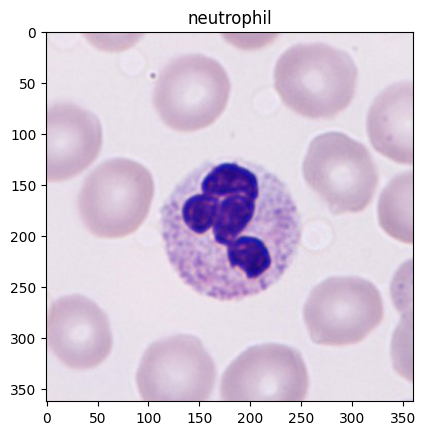

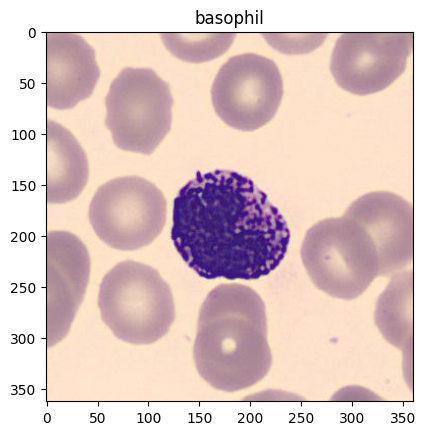

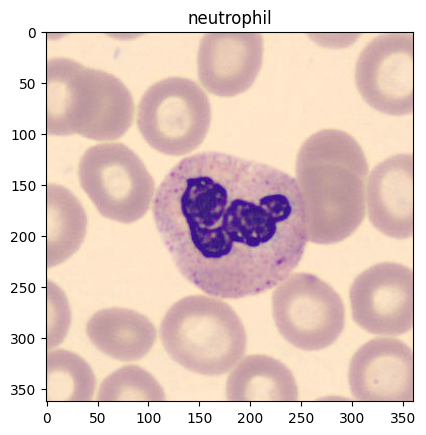

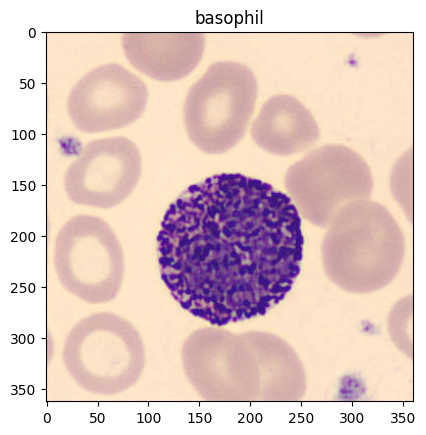

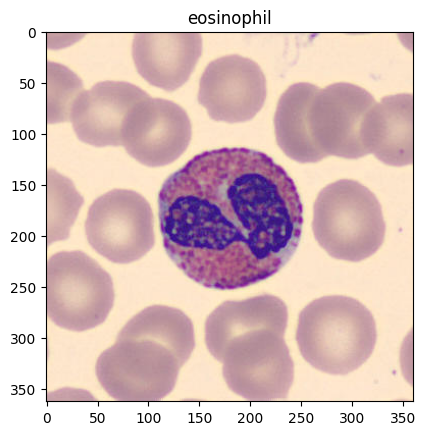

In [8]:
def graph_cell(img, label, memo=""):
    """
    img: a torch.Tensor or a np.ndarray
    label: an integer
    """
    if type(img) == torch.Tensor:
        img = img.detach().cpu().numpy().squeeze()
    img = np.transpose(img.squeeze(), (1, 2, 0))
    plt.imshow(img)
    plt.title((idx2class[label]) + memo)
    plt.show()

for i in range(5):
    img, label = training_data[i]
    graph_cell(img, label.item())

In [9]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device("cuda")
print("Using device:", device)

Using device: cpu


In [10]:
class BloodCell_CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Define the convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Define the max-pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Define the fully connected layers
        self.fc1 = nn.Linear(128 * 45 * 45, 256)
        self.fc2 = nn.Linear(256, 3)  # Output size is 3 for the three blood cell types

        # Define the activation functions
        self.relu = nn.ReLU()

    def forward(self, X):
        if len(X.shape) == 3:  # If one single image is passed, make sure it's of dimension (1, 3, H, W)
            X = X.unsqueeze(0)

        # Convolutional layers
        X = self.relu(self.conv1(X))
        X = self.pool(X)  # Output shape: (batch_size, 32, 181, 180)
        X = self.relu(self.conv2(X))
        X = self.pool(X)  # Output shape: (batch_size, 64, 90, 90)
        X = self.relu(self.conv3(X))
        X = self.pool(X)  # Output shape: (batch_size, 128, 45, 45)

        # Flatten the output of the convolutional layers
        X = X.reshape(-1, 128 * 45 * 45)

        # Fully connected layers
        X = self.relu(self.fc1(X))
        logits = self.fc2(X)

        return logits

    def classify(self, X):
        logits = self.forward(X)
        return torch.argmax(logits, dim=1)


In [11]:
from sklearn.metrics import accuracy_score
from copy import deepcopy

def train(model, training_data, testing_data, epochs=15, batch_size=16, lr=1e-3):
    """
    Train the model on the training data and evaluate on the validation data.

    Inputs
    - model: the model to be trained - a PyTorch nn.Module class object
    - training_data: training data (BloodCell_Dataset object)
    - testing_data: validation data (BloodCell_Dataset object)
    - epochs: num epochs, or the number of times we want to run through the entire training data
    - batch_size: number of data points per batch
    - lr: learning rate

    Outputs
    - losses: a list of losses
    - accuracies: a list of validation accuracies
    """

    torch.cuda.empty_cache()
    model = model.to(device)

    train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=False)

    best_acc = -1
    best_model = None

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses = []
    accuracies = []

    for epoch in range(epochs):
        epoch_loss = 0.0
        for imgs, labels in iter(train_dataloader):
            imgs = imgs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            logits = model(imgs)
            loss = loss_fn(logits, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Calculate validation accuracy
        model.eval()
        with torch.no_grad():
            X_val, y_val = testing_data.tensor_imgs.to(device), testing_data.labels.to(device)
            val_logits = model(X_val)
            val_preds = torch.argmax(val_logits, dim=1)
            accuracy = accuracy_score(y_val.cpu().numpy(), val_preds.cpu().numpy())
        model.train()

        losses.append(epoch_loss / len(train_dataloader))
        accuracies.append(accuracy)

        if accuracy > best_acc:
            best_acc = accuracy
            best_model = deepcopy(model)

        print(f"Epoch {epoch + 1}:\tloss {np.round(losses[-1], 4)}\t& accuracy {np.round(accuracy, 4)}")

    print(f"Resetting model... Best validation accuracy:\t{np.round(best_acc, 4)}")
    model.load_state_dict(best_model.state_dict())
    return losses, accuracies

In [12]:
model = BloodCell_CNN()
losses, accuracies = train(model, training_data, testing_data, batch_size=16, epochs=5)

Epoch 1:	loss 1.5332	& accuracy 0.5306
Epoch 2:	loss 0.8226	& accuracy 0.8061
Epoch 3:	loss 0.539	& accuracy 0.8163
Epoch 4:	loss 0.341	& accuracy 0.8571
Epoch 5:	loss 0.2645	& accuracy 0.8265
Resetting model... Best validation accuracy:	0.8571


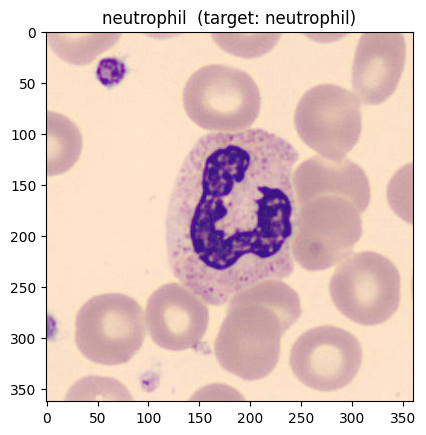

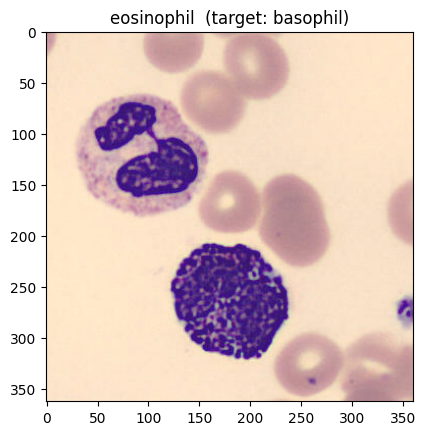

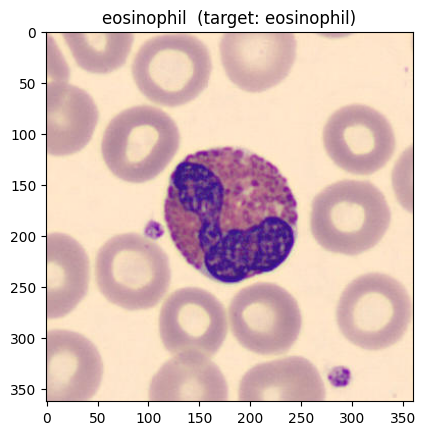

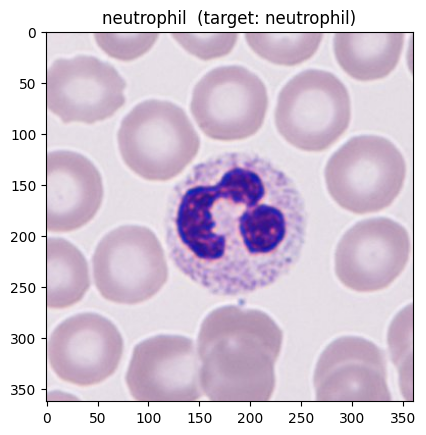

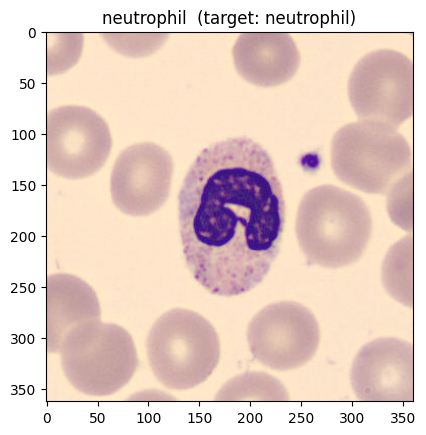

In [13]:
torch.cuda.empty_cache()
imgs = testing_data.tensor_imgs[:5]
labels = testing_data.labels[:5]
preds = model.classify(imgs.to(device))
for i in range(5):
    graph_cell(imgs[i], preds[i].item(), memo=f"  (target: {idx2class[labels[i].numpy().item()]})")

In [14]:
# empty some RAM
torch.cuda.empty_cache()
del testing_data
del training_data

test_path = "./bloodcells_dataset/test_data.npy"

test = np.load(test_path)
test = torch.tensor(test).type(torch.float32).to(device) / 255
test = test.permute(0, 3, 1, 2)

# split the hidden test data in half to avoid GPU memory problems
preds1 = model.classify(test[:71])
preds1 = preds1.detach().cpu().numpy()
torch.cuda.empty_cache()
preds2 = model.classify(test[71:])
preds2 = preds2.detach().cpu().numpy()
preds = np.concatenate([preds1.flatten(), preds2.flatten()])
np.save("./predictions.npy", preds)
print("Predictions saved!")

Predictions saved!
